# Training 3D ResNet model for multi-class classification

In [1]:
# !pip install monai
# !pip install matplotlib, huggingface-hub
# !pip install -c conda-forge pytorch-gpu

# The following magic causes the notebook to reload external python modules upon execution of a cell
# This is useful when developing modules in parallel to the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, MetaTensor, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    ScaleIntensityRanged, 
    CropForegroundd, 
    Orientationd, 
    Spacingd, 
    EnsureTyped, 
    Activations, 
    AsDiscrete, 
    Resized, 
    RandFlipd, 
    RandRotate90d, 
    RandZoomd,
    RandGridPatchd,
    Resized
)
from monai.networks.nets import resnet50
from monai.metrics import ROCAUCMetric

## Prepare the dataset

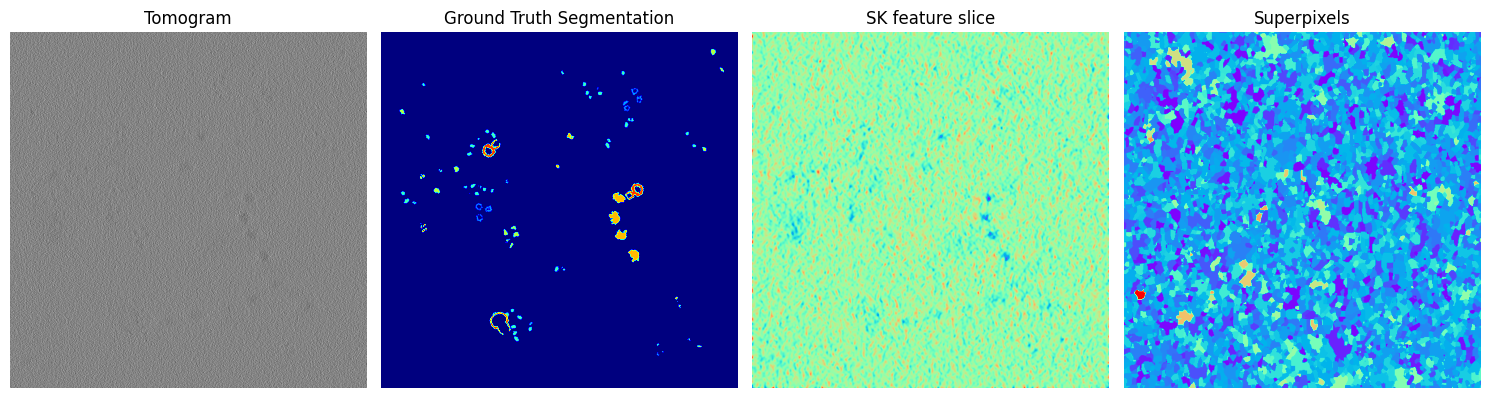

In [3]:
import pickle
import matplotlib.pyplot as plt

# Load data from a file
with open('../copick_10439/dataset_run_16194.pickle', 'rb') as f1:  # 'rb' means read in binary mode
    train_files = pickle.load(f1)

with open('../copick_10439/dataset_run_16195.pickle', 'rb') as f2:  # 'rb' means read in binary mode
    val_files = pickle.load(f2)    
    
    

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('Tomogram')
plt.imshow(train_files['image'][20],cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(train_files['label'][20], cmap="jet")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('SK feature slice')
plt.imshow(train_files['sk_features'][10][:,:,10], cmap="rainbow")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Superpixels')
plt.imshow(train_files['superpixels'][20], cmap="rainbow")
plt.axis('off')

plt.tight_layout()
plt.show()

## Prepare dataloaders

In [4]:
# Define transforms for image and segmentation
transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    #CropForegroundd(keys=["image"], source_key="image"),
    #Orientationd(keys=["image"], axcodes="RAS"),
    #Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image"]),
    RandRotate90d(keys=["image"], prob=0.5, spatial_axes=(1, 2)),
    RandFlipd(keys=["image"], prob=0.5, spatial_axis=0),
    Resized(keys=["image"], spatial_size=(64, 64, 64))
    # RandZoomd(keys=["image"], prob=0.2, min_zoom=0.9, max_zoom=1.1),
    # RandGridPatchd(keys=["image"], patch_size=(96, 96, 96), patch_overlap=(32, 32, 32)),  # Tiling into patches 
])


val_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    #CropForegroundd(keys=["image"], source_key="image"),
    #Orientationd(keys=["image"], axcodes="RAS"),
    #Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    EnsureTyped(keys=["image"]),
    # RandRotate90d(keys=["image"], prob=0.5, spatial_axes=(1, 2)),
    # RandFlipd(keys=["image"], prob=0.5, spatial_axis=0),
    Resized(keys=["image"], spatial_size=(64, 64, 64))
    # RandZoomd(keys=["image"], prob=0.2, min_zoom=0.9, max_zoom=1.1),
    # RandGridPatchd(keys=["image"], patch_size=(96, 96, 96), patch_overlap=(32, 32, 32)),  # Tiling into patches 
])

In [5]:
from scipy import ndimage, stats
import pandas as pd

def get_labels_pd_series(superpixels, gt):
    spp_idx = []
    labels = []
    for sppi,obj in tqdm(enumerate(ndimage.find_objects(superpixels), start=1)):
        if obj is None:
            continue
    
        mask = superpixels[obj] == sppi
        most_label, count = stats.mode(gt[obj][mask])
        spp_idx.append(sppi)
        labels.append(most_label)
    
    return pd.Series(labels, index=spp_idx)

In [6]:
from cellcanvas_spp.data import SuperpixelsDataset


train_ds = SuperpixelsDataset(image=train_files["image"],
                              superpixels=train_files["superpixels"],
                              labels=get_labels_pd_series(train_files["superpixels"], train_files["label"]),
                              remove_background=True,
                              transform=transforms)  

val_ds = SuperpixelsDataset(image=val_files["image"],
                            superpixels=val_files["superpixels"],
                            labels=get_labels_pd_series(val_files["superpixels"], val_files["label"]),
                            remove_background=True,
                            transform=val_transforms) 

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=32, num_workers=4, pin_memory=torch.cuda.is_available())

79380000it [00:29, 2669612.20it/s]
79380000it [00:28, 2740708.06it/s]


In [7]:
torch.cuda.is_available()

True

In [8]:
# import numpy as np
# x = np.zeros((10, 15, 25))
# transforms({"image": x, "label": 1})

In [9]:
# train_ds.transform = transforms
for batch in train_loader:
    print(batch["image"].shape)
    print(batch["image"].dtype)
    print(batch["label"].shape)
    break
    #print(data)

torch.Size([32, 1, 64, 64, 64])
torch.float32
torch.Size([32])


## Model setup

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = resnet50(
    pretrained=False, 
    spatial_dims=3, 
    n_input_channels=1, 
    num_classes=8,
    #feed_forward=False
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
loss_function = torch.nn.CrossEntropyLoss()
auc_metric = ROCAUCMetric()

cuda


In [17]:
from monai.inferers import sliding_window_inference

def stack_patches(data):
    shape = data.shape
    new_shape = (shape[0] * shape[1],) + shape[2:]
    return data.view(new_shape)
        

post_pred = Compose([Activations(softmax=True)])
post_label = Compose([AsDiscrete(to_onehot=8)])

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    metrics_function.reset()
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    best_train_loss = 1
    best_loss_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in tqdm(train_loader):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].long().to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            #print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            best_loss_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join('./', "best_loss_model.pth"))
            print("saved new best train loss model")
        
        print(
            f"\nbest train loss: {best_train_loss:.4f} "
            f"at epoch: {best_loss_epoch}"
        )
            
    
#         if (epoch + 1) % val_interval == 0:
#             model.eval()
#             with torch.no_grad():
#                 s = 0
#                 for val_data in val_loader:
#                     s += 1
#                     val_inputs, val_labels = (
#                         val_data["image"].to(device),
#                         val_data["label"].long().to(device),
#                     )
#                     # roi_size = (64, 64, 64)
#                     # sw_batch_size = 4
#                     val_outputs = model(val_inputs)
#                     # val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#                     val_outputs = torch.stack([post_pred(i) for i in decollate_batch(val_outputs)]).to(device)
#                     val_labels = torch.stack([post_label(i) for i in decollate_batch(val_labels)]).to(device)
#                     # compute metric for current iteration
#                     metrics_function(y_pred=val_outputs, y=val_labels)

#                 metric = metrics_function.aggregate().item()
#                 metrics_function.reset()

#                 metric_values.append(metric)
#                 if metric > best_metric:
#                     best_metric = metric
#                     best_metric_epoch = epoch + 1
#                     torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
#                     print("saved new best metric model")
#                 print(
#                     f"current epoch: {epoch + 1} current mean auc_metric: {metric:.4f}"
#                     f"\nbest mean auc_metric: {best_metric:.4f} "
#                     f"at epoch: {best_metric_epoch}"
#                 )

## Training and tracking

In [ ]:
epochs = 100
train(train_loader, model, loss_function, auc_metric, optimizer, max_epochs=epochs)

----------
epoch 1/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 1 average loss: 0.0860
saved new best train loss model

best train loss: 0.0860 at epoch: 1
----------
epoch 2/100


100%|██████████| 1275/1275 [08:47<00:00,  2.42it/s]


epoch 2 average loss: 0.0785
saved new best train loss model

best train loss: 0.0785 at epoch: 2
----------
epoch 3/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 3 average loss: 0.0763
saved new best train loss model

best train loss: 0.0763 at epoch: 3
----------
epoch 4/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 4 average loss: 0.0768

best train loss: 0.0763 at epoch: 3
----------
epoch 5/100


100%|██████████| 1275/1275 [08:45<00:00,  2.43it/s]


epoch 5 average loss: 0.0733
saved new best train loss model

best train loss: 0.0733 at epoch: 5
----------
epoch 6/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 6 average loss: 0.0742

best train loss: 0.0733 at epoch: 5
----------
epoch 7/100


100%|██████████| 1275/1275 [08:45<00:00,  2.43it/s]


epoch 7 average loss: 0.0738

best train loss: 0.0733 at epoch: 5
----------
epoch 8/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 8 average loss: 0.0713
saved new best train loss model

best train loss: 0.0713 at epoch: 8
----------
epoch 9/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 9 average loss: 0.0726

best train loss: 0.0713 at epoch: 8
----------
epoch 10/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 10 average loss: 0.0712
saved new best train loss model

best train loss: 0.0712 at epoch: 10
----------
epoch 11/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 11 average loss: 0.0707
saved new best train loss model

best train loss: 0.0707 at epoch: 11
----------
epoch 12/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 12 average loss: 0.0714

best train loss: 0.0707 at epoch: 11
----------
epoch 13/100


100%|██████████| 1275/1275 [08:45<00:00,  2.43it/s]


epoch 13 average loss: 0.0701
saved new best train loss model

best train loss: 0.0701 at epoch: 13
----------
epoch 14/100


100%|██████████| 1275/1275 [08:44<00:00,  2.43it/s]


epoch 14 average loss: 0.0699
saved new best train loss model

best train loss: 0.0699 at epoch: 14
----------
epoch 15/100


 26%|██▌       | 327/1275 [02:14<06:30,  2.43it/s]

In [65]:
torch.stack([post_label(i) for i in range(5)])

metatensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])